# Orientation and direction selectivity analysis

In [131]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('..')
from physion.dataviz import plots
from physion.analysis.read_NWB import read as read_NWB
from physion.analysis.trial_averaging import build_episodes
from physion.visual_stim.psychopy_code.stimuli import build_stim

# we define a data object fitting this analysis purpose

class Data:
    
    def __init__(self, filename, 
                 protocol_id=0,
                 quantity='CaImaging', 
                 subquantity='Fluorescence', 
                 roiIndex = 0,
                 verbose=False):
        """ opens data file and build the episodes corresponding to a specific protocol """
        read_NWB(self, filename, verbose=verbose)
        if verbose:
            print('Building episodes for "%s"' % self.protocols[protocol_id])
        self.CaImaging_key, self.roiIndices = subquantity, [roiIndex]
        self.EPISODES = build_episodes(self, protocol_id=protocol_id, quantity=quantity)
        
    def compute_repeated_trials(self, key, index):
        cond = (self.EPISODES[key]==self.varied_parameters[key][index])
        return np.mean(self.EPISODES['resp'][cond,:], axis=0), np.std(self.EPISODES['resp'][cond,:], axis=0)
    
    def compute_integral_responses(self, key):
        integrals = []
        for i, value in enumerate(self.varied_parameters[key]):
            mean_response, _ = self.compute_repeated_trials(key, i)
            pre_cond = (self.EPISODES['t']<=0)
            stim_cond = (self.EPISODES['t']>0) & (self.EPISODES['t']<=data.EPISODES['time_duration'][0])
            integrals.append(np.trapz(mean_response[stim_cond]-np.mean(mean_response[pre_cond])))        
        return self.varied_parameters[key], np.array(integrals)
    
    def plot(self, key, index, ax=None, with_std=True, with_bars={}):
        if ax is None:
            _, ax = plt.subplots(1)
            ax.axis('off')
        my, sy = self.compute_repeated_trials(key, index)
        ax.plot(self.EPISODES['t'], my, color='k')
        if with_std:
            ax.fill_between(self.EPISODES['t'], my-sy, my+sy, alpha=0.1, color='k', lw=0)
            
    def add_stim(self, ax):
        ylim = ax.get_ylim()
        ax.fill_between([0, data.EPISODES['time_duration'][0]], ylim[0]*np.ones(2), ylim[1]*np.ones(2), lw=0, color='grey', alpha=0.1)
    
    
    def show_stim(self, key, figsize=(15,2), with_arrow=False):
        fig, AX = plt.subplots(1, len(self.varied_parameters[key]), figsize=figsize)
        self.metadata['load_from_protocol_data'], self.metadata['no-window'] = True, True
        visual_stim = build_stim(self.metadata, no_psychopy=True)
        for i, value in enumerate(self.varied_parameters[key]):
            AX[i].set_title('%.0f$^o$' % value)
            icond = np.argwhere(self.nwbfile.stimulus[key].data[:]==value)[0][0]
            if with_arrow:
                visual_stim.show_frame(icond, ax=AX[i],
                                       arrow={'direction':value, 'center':(0,0),
                                              'length':25,
                                              'width_factor':0.1, 'color':'red'},
                                    label={'degree':10, 'shift_factor':0.02, 'lw':1, 'fontsize':11})
            else:
                visual_stim.show_frame(icond, ax=AX[i],
                                    label={'degree':10, 'shift_factor':0.02, 'lw':1, 'fontsize':11})
        return fig, AX
            
def add_bar(ax, Ybar=1, Ybar_unit='$\Delta$F/F', Xbar=1, Xbar_unit='s', fontsize=11):
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    dx, dy = .02*(xlim[1]-xlim[0]), .02*(ylim[1]-ylim[0])
    ax.plot([xlim[0]-dx, xlim[0]-dx+Xbar], [ylim[1]-dy, ylim[1]-dy], 'k')
    ax.plot([xlim[0]-dx, xlim[0]-dx], [ylim[1]-dy, ylim[1]-dy-Ybar], 'k')
    ax.annotate(str(Ybar)+Ybar_unit, (xlim[0], ylim[1]), xycoords='data', ha='right', va='top', rotation=90, fontsize=fontsize)
    ax.annotate(str(Xbar)+Xbar_unit, (xlim[0], ylim[1]), xycoords='data', fontsize=fontsize)#,ha='left', va='top')
    

def orientation_selectivity_index(angles, resp):
    imax = np.argmax(resp)
    iop = np.argmin(((angles[imax]+90)%(180)-angles)**2)
    return min([1,max([0,(resp[imax]-resp[iop])/(resp[imax]+resp[iop])])])

def orientation_selectivity_plot(angles, responses, ax=None, figsize=(2.5,1.5)):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.plot(angles, responses, color='k', lw=2)
    ax.annotate('SI=%.2f ' % orientation_selectivity_index(angles, responses), (1, 1), 
                va='top', ha='right', xycoords='axes fraction', weight='bold')
    ax.set_xticks(angles)
    ax.set_ylabel('response integral ($\Delta$F/F.s)')
    ax.set_xlabel('angle ($^o$)')

def direction_selectivity_plot(angles, responses, ax=None, figsize=(1.5,1.5)):
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.axes([0,0,1,1], projection='polar')
    ax.set_theta_direction(-1)
    Angles = angles*np.pi/180.
    ax.plot(np.concatenate([Angles, [Angles[0]]]), np.concatenate([responses, [responses[0]]]), color='k', lw=2)
    ax.fill_between(np.concatenate([Angles, [Angles[0]]]), np.zeros(len(Angles)+1),
                    np.concatenate([responses, [responses[0]]]), color='k', lw=0, alpha=0.3)
    ax.set_rticks([])
    ax.annotate('SI=%.2f ' % orientation_selectivity_index(angles, responses), (1, 1), 
                va='top', ha='right', xycoords='figure fraction', weight='bold')


## Datafile

We take a datafile that intermixes static and drifting gratings visual stimulation in a pseudo-randomized sequence

In [132]:
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'data.nwb')


# Orientation selectivity

Number of episodes over the whole recording: 40/120 (with protocol condition)
321.47202 199.06458593925404
Problem with episode 0 between (1.02, 6.02)s
Problem with episode 119 between (1193.52, 1198.52)s
[ok] episodes ready !


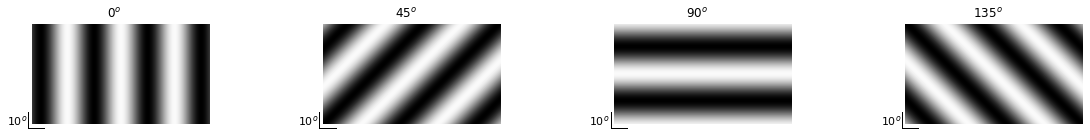

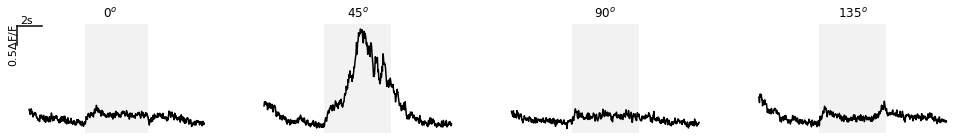

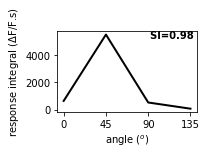

In [133]:
# Load data for FIRST PROTOCOL
data = Data(filename, protocol_id=0, quantity='CaImaging', subquantity='dF/F', roiIndex = 8)
# Show stimulation
fig, AX = data.show_stim('angle', figsize=(20,2))
# Compute and plot trial-average responses
fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(17,2.))
for i, angle in enumerate(data.varied_parameters['angle']):
    data.plot('angle',i, ax=AX[i], with_std=False)
    AX[i].set_title('%.0f$^o$' % angle)
# put all on the same axis range
YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
for ax in AX:
    ax.set_ylim(YLIM)
    data.add_stim(ax)
    ax.axis('off')
# add scale bar
add_bar(AX[0], Xbar=2, Ybar=0.5)
# Orientation selectivity plot based on the integral of the trial-averaged response
orientation_selectivity_plot(*data.compute_integral_responses('angle'))
# close the nwbfile
#data.io.close()

# Direction selectivity

Number of episodes over the whole recording: 80/120 (with protocol condition)
321.47202 199.06458593925404
[ok] episodes ready !


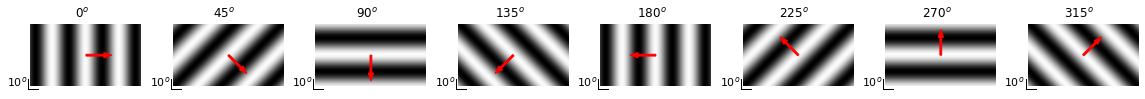

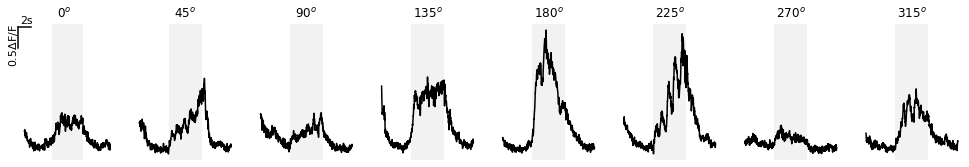

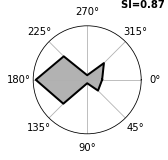

In [119]:
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'data.nwb')
# Load data for FIRST PROTOCOL
data = Data(filename, protocol_id=1, quantity='CaImaging', subquantity='dF/F', roiIndex = 8)
# Show stimulation
fig, AX = data.show_stim('angle', figsize=(20,2), with_arrow=True)
# Compute and plot trial-average responses
fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(17,2.))
for i, angle in enumerate(data.varied_parameters['angle']):
    data.plot('angle',i, ax=AX[i], with_std=False)
    AX[i].set_title('%.0f$^o$' % angle)
# put all on the same axis range
YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
for ax in AX:
    ax.set_ylim(YLIM)
    data.add_stim(ax)
    ax.axis('off')
# add scale bar
add_bar(AX[0], Xbar=2, Ybar=0.5)
# Orientation selectivity plot based on the integral of the trial-averaged response
direction_selectivity_plot(*data.compute_integral_responses('angle'))
# close the nwbfile
#data.io.close()